In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading and Exploring the Data Set

In [11]:
# Load the dataset
df = pd.read_csv('transaction_history.csv')

# Display first 5 rows
print(df.head())

# Basic info
print("\nDataset Info:")
print(df.info())

# Statistical summary
print("\nStatistical Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Check class distribution
print("\nFraud Class Distribution:")
print(df['is_fraud'].value_counts())

                         transaction_id            timestamp    sender  \
0  ddbb2a5c-0731-4d37-8db2-9540cdb8034e  2025-03-17T03:37:47  JQIAGBXJ   
1  203010b1-25db-4323-a968-9d6062092e50  2025-02-02T09:02:50  LYIQGBJU   
2  361ca67d-0023-4913-a978-1e4237d59e52  2025-03-06T18:40:26  KSNTGBI8   
3  d0f6d62b-8317-4f2a-bce4-ea057d830633  2025-03-19T04:07:23  HUIUGB4X   
4  7b573829-188c-4a5a-8da2-4d3fdf5ed8c7  2025-01-04T10:14:23  XUHDGBNH   

   receiver    amount currency  location  is_fraud  
0  MZZWGB4E   5769.29      GBP      Fiji         1  
1  ZLOZGBBE   6981.84      EUR     Kenya         1  
2  QPPYGB2X   5378.31      INR   Albania         1  
3  IYTMGBBT  18288.33      USD  Barbados         1  
4  BYAPGBHJ  12212.46      EUR   Belarus         0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   transaction_id  

#### Data Preprocessing

In [12]:
# Convert timestamp to datetime and extract features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Encode categorical variables
label_encoders = {}
categorical_cols = ['currency', 'location', 'sender', 'receiver']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature scaling
scaler = StandardScaler()
numerical_cols = ['amount', 'hour', 'day_of_week', 'month']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Prepare features and target
X = df.drop(['transaction_id', 'timestamp', 'is_fraud'], axis=1)
y = df['is_fraud']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (70000, 8)
Test set shape: (30000, 8)


#### Model Traning

In [13]:
# Initialize and train Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for fraud class

#### Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52     15019
           1       0.50      0.46      0.48     14981

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000


Confusion Matrix:
[[8063 6956]
 [8066 6915]]

Accuracy Score: 0.4992666666666667


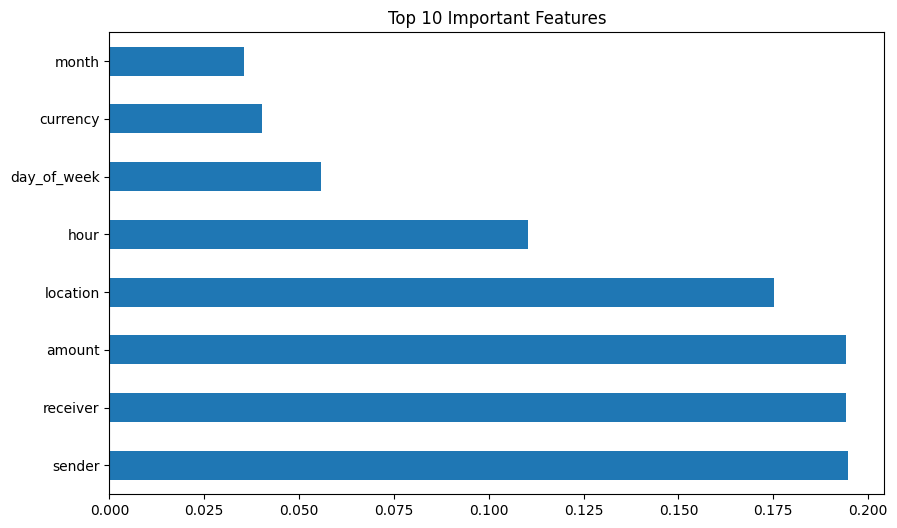

In [14]:
# Evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

#### Save The Model

In [15]:
import joblib

# Save the model and preprocessing objects
joblib.dump(rf_model, 'fraud_detection_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and preprocessing objects saved successfully.")

Model and preprocessing objects saved successfully.


#### Create a Prediction Function (for API)

In [16]:
def predict_fraud(transaction_data):
    """
    Predict whether a transaction is fraudulent
    
    Args:
        transaction_data (dict): Dictionary containing transaction details
        
    Returns:
        dict: Prediction result with probabilities
    """
    # Load saved models
    model = joblib.load('fraud_detection_model.pkl')
    label_encoders = joblib.load('label_encoders.pkl')
    scaler = joblib.load('scaler.pkl')
    
    # Create a DataFrame from input data
    input_df = pd.DataFrame([transaction_data])
    
    # Preprocess the input data
    input_df['timestamp'] = pd.to_datetime(input_df['timestamp'])
    input_df['hour'] = input_df['timestamp'].dt.hour
    input_df['day_of_week'] = input_df['timestamp'].dt.dayofweek
    input_df['month'] = input_df['timestamp'].dt.month
    
    # Encode categorical variables
    for col in ['currency', 'location', 'sender', 'receiver']:
        le = label_encoders[col]
        input_df[col] = le.transform(input_df[col])
    
    # Scale numerical features
    numerical_cols = ['amount', 'hour', 'day_of_week', 'month']
    input_df[numerical_cols] = scaler.transform(input_df[numerical_cols])
    
    # Prepare final features
    X = input_df.drop(['transaction_id', 'timestamp'], axis=1)
    
    # Make prediction
    prediction = model.predict(X)[0]
    prediction_proba = model.predict_proba(X)[0]
    
    return {
        'prediction': 'Fraud' if prediction == 1 else 'Not Fraud',
        'probability_fraud': float(prediction_proba[1]),
        'probability_legitimate': float(prediction_proba[0])
    }

#### Example Usage

In [17]:
# Example transaction data
example_transaction = {
    "transaction_id": "test123",
    "timestamp": "2025-03-20T15:30:00",
    "sender": "JQIAGBXJ",  # Must be from existing senders in training data
    "receiver": "MZZWGB4E",  # Must be from existing receivers in training data
    "amount": 15000,
    "currency": "GBP",
    "location": "Fiji"
}

# Make prediction
result = predict_fraud(example_transaction)
print("\nPrediction Result:")
print(result)


Prediction Result:
{'prediction': 'Not Fraud', 'probability_fraud': 0.47, 'probability_legitimate': 0.53}


#### Visualiztaion

In [18]:
#1. Fraud Distribution by Time
import plotly.express as px

# Create time-based features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day_name()
df['month'] = df['timestamp'].dt.month_name()

# Fraud by hour of day
fig1 = px.histogram(df, x='hour', color='is_fraud', 
                   title='Fraud Distribution by Hour of Day',
                   labels={'is_fraud': 'Fraud Status', 'hour': 'Hour of Day'},
                   color_discrete_map={0: '#2ecc71', 1: '#e74c3c'},
                   barmode='group', nbins=24)

fig1.update_layout(
    xaxis=dict(tickmode='linear', dtick=1),
    plot_bgcolor='rgba(245,245,245,1)',
    paper_bgcolor='rgba(245,245,245,1)'
)
fig1.show()

In [ ]:
#2. Interactive Currency vs Fraud Sunburst Chart
import plotly.express as px

# Prepare data
currency_fraud = df.groupby(['currency', 'is_fraud']).size().reset_index(name='counts')

fig = px.sunburst(currency_fraud, path=['currency', 'is_fraud'], values='counts',
                 color='is_fraud',
                 color_continuous_scale=['#27ae60', '#e74c3c'],
                 title='Fraud Distribution Across Currencies',
                 labels={'is_fraud': 'Fraud Status', 'counts': 'Transaction Count'})

fig.update_traces(textinfo="label+percent parent")
fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
fig.show()